In [1]:
import os
import h5py
import json
import numpy as np
import pandas as pd
import nibabel as nib
from pathlib import Path

from scipy import stats
from sklearn import svm
from statsmodels.stats.multitest import multipletests
from scipy.stats import ttest_1samp
from sklearn.model_selection import cross_val_score, StratifiedKFold
from scipy.stats import pearsonr

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
from helper import decoding
from utils import filter_task_betas, beta_concatenation, make_brain_surface_plot, df_concatenation

In [3]:
# load glasser atlas
parent_dir = Path.cwd().parent
glasser_atlas_str= os.path.join(parent_dir,'data', 'Glasser_LR_Dense64k.dlabel.nii')
glasser_atlas = nib.load(glasser_atlas_str).get_fdata()[0].astype(int)
print("Glassier Atlas shape:", glasser_atlas.shape)
num_regions = 360
num_cole_network_partition = 12

Glassier Atlas shape: (64984,)


In [4]:
# run this before loading the accuracy data
# load Cole cortex parcellated network
file_path_base = "/home/xiaoxuan/projects/ColeAnticevicNetPartition/"
filename = "cortex_parcel_network_assignments.txt"
print(os.path.join(file_path_base, filename))
network_region_assignment = np.loadtxt(os.path.join(file_path_base, filename), dtype=int)

# map region_wise assignment to voxel-wise based on Glasser atlas
network_voxelwise_assignment = np.zeros((glasser_atlas.shape[0], 1))

# Perform statistical analysis for each brain region
len_region_idx = 0
for region in range(1, 361):
    region_idx = np.where(glasser_atlas == region)[0]
    len_region_idx += len(region_idx)
    network_voxelwise_assignment[region_idx] = network_region_assignment[region-1]
    
network_partition_names = {
    "1": "primary visual",
    "2": "secondary visual",
    "3": "somatomotor",
    "4": "cingulo-opercular",
    "5": "dorsal attention",
    "6": "language",
    "7": "frontparietal",
    "8": "auditory",
    "9": "default mode",
    "10": "posterior multimodal",
    "11": "ventral multimodal",
    "12": "orbito-affective",
}

/home/xiaoxuan/projects/ColeAnticevicNetPartition/cortex_parcel_network_assignments.txt


In [5]:
# read the data
file_path_base = "/home/xiaoxuan/projects/202406_fMRI/network_level_results/"

ctg_relevant_group = [s + "_category" for s in ["1backctg", "interdmsctgABAB", "interdmsctgABBA"]]
ctg_irrelevant_group = [s + "_category" for s in ["dmsloc", "1backloc", "interdmslocABBA", "interdmslocABAB", "1backobj", "interdmsobjABAB", "interdmsobjABBA"]]
loc_relevant_group = [s + "_location" for s in ["dmsloc", "1backloc", "interdmslocABBA", "interdmslocABAB"]]
loc_irrelevant_group = [s + "_location" for s in ["1backctg", "interdmsctgABAB", "interdmsctgABBA", "1backobj", "interdmsobjABAB", "interdmsobjABBA"]]

phases = ["encoding", "delay"]
n_reps = 10

all_tasks = ctg_relevant_group + ctg_irrelevant_group + loc_relevant_group + loc_irrelevant_group

## decoding at network level 
make figures for encoding and delay period, with x-axis being network, and y-axis being decoding accuracy

In [ ]:
# Network partition names mapping
network_partition_names = {
    1: "Primary Visual",
    2: "Secondary Visual",
    3: "Somatomotor",
    4: "Cingulo-Opercular",
    5: "Dorsal Attention",
    6: "Language",
    7: "Frontoparietal",
    8: "Auditory",
    9: "Default Mode",
    10: "Posterior Multimodal",
    11: "Ventral Multimodal",
    12: "Orbito-Affective",
}

# Dictionary to store decoding accuracy values for each network partition
network_acc = {network_idx: {'delay': [], 'encoding': []} for network_idx in network_partition_names.keys()}

for task_name in all_tasks:  # Pool data across all tasks
    for phase in phases:
        for rep in range(1, n_reps + 1):
            curr_file_path = os.path.join(file_path_base, task_name + f"_{phase}")
            pval_path = os.path.join(curr_file_path, f"p_values_map_corrected_rep{rep}.npy")

            if not os.path.exists(pval_path):
                print(f"Data not exist for {phase} {task_name} rep{rep}")
                break

            # Load necessary data
            p_values_map = np.load(os.path.join(curr_file_path, f"p_values_map_rep{rep}.npy"))
            regionwise_acc = np.load(os.path.join(curr_file_path, f"regionwise_acc_rep{rep}.npy"))

            # FDR correction
            reject, pvals_corrected, _, _ = multipletests(p_values_map.squeeze(), alpha=0.05, method='fdr_bh')
            fdr_corrected_acc = np.zeros_like(regionwise_acc)
            fdr_corrected_acc[reject] = regionwise_acc[reject]

            # Collect accuracy values by network partition
            for network_index in network_partition_names.keys():
                indices = np.where(network_voxelwise_assignment == network_index)[0]
                acc_values = fdr_corrected_acc[indices]

                # Exclude zero values (non-decodable regions)
                acc_values = acc_values[acc_values > 0]
                if len(acc_values) > 0:  # Only store non-zero values
                    network_acc[network_index][phase].extend(acc_values.tolist())

# Convert to DataFrame for plotting
plot_data = []
for network_index, phase_dict in network_acc.items():
    for phase, acc_list in phase_dict.items():
        for acc in acc_list:
            plot_data.append({
                "Network": network_partition_names[network_index],
                "Accuracy": acc,
                "Phase": phase
            })

df = pd.DataFrame(plot_data)

# Ensure we don't plot empty data
if not df.empty:
    plt.figure(figsize=(12, 6))
    sns.boxplot(x="Network", y="Accuracy", hue="Phase", data=df, palette="Set2", showmeans=True)
    sns.stripplot(x="Network", y="Accuracy", hue="Phase", data=df, dodge=True, jitter=True, alpha=0.5, marker='o')

    plt.xlabel("Network Partition")
    plt.ylabel("Decoding Accuracy")
    plt.title("Decoding Accuracy Across Network Partitions (Pooled Across Tasks)")
    plt.legend(title="Phase")
    plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for readability
    plt.tight_layout()
    plt.show()


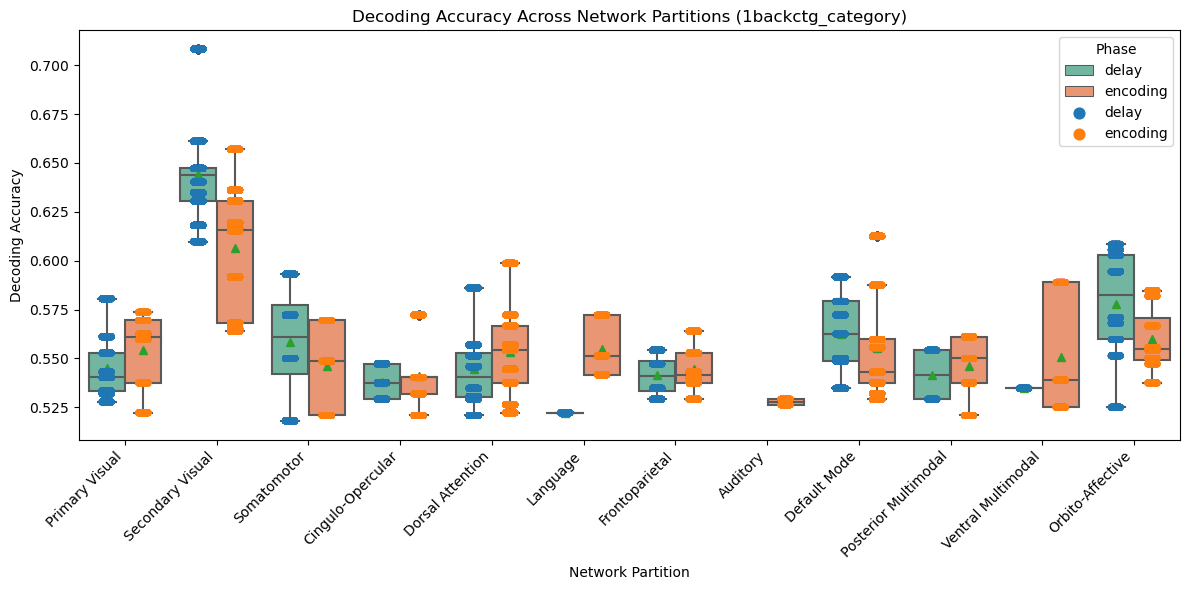

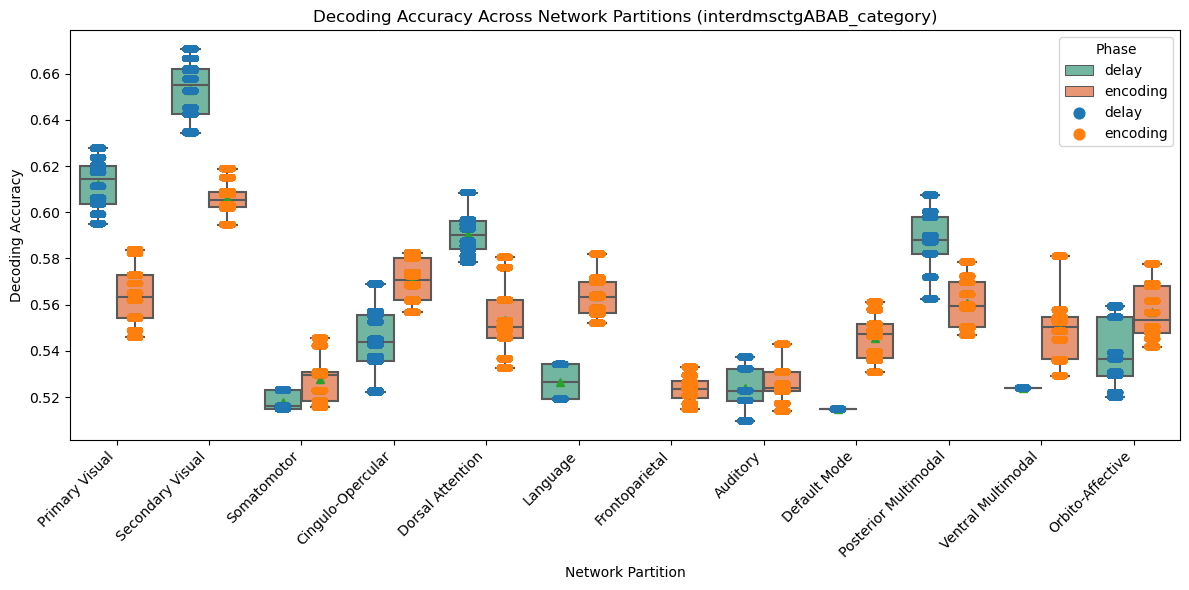

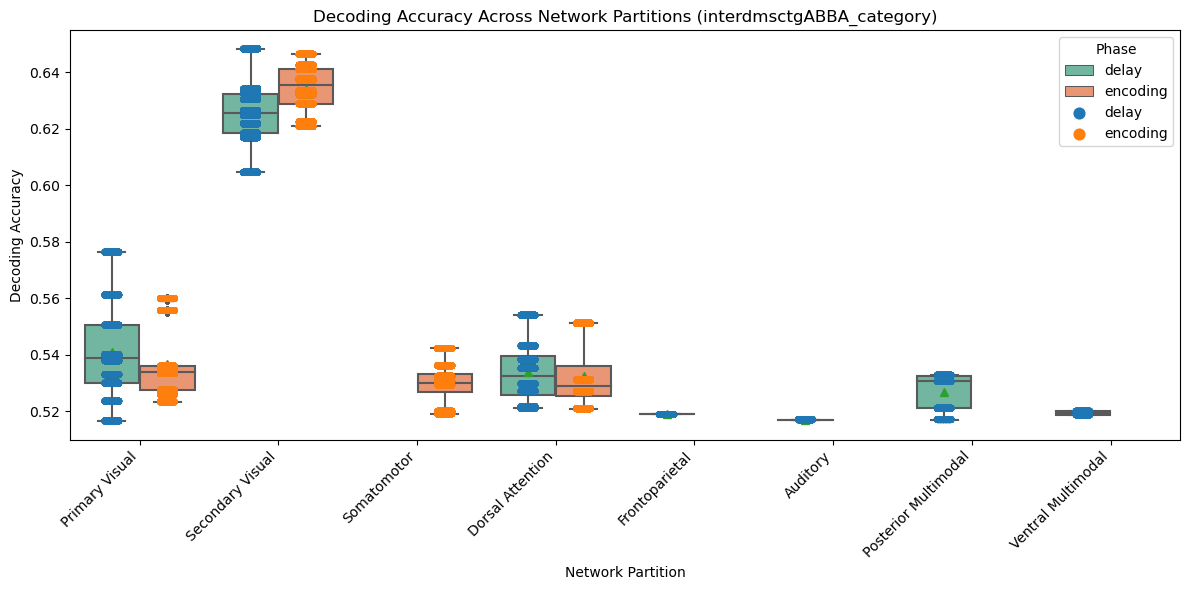

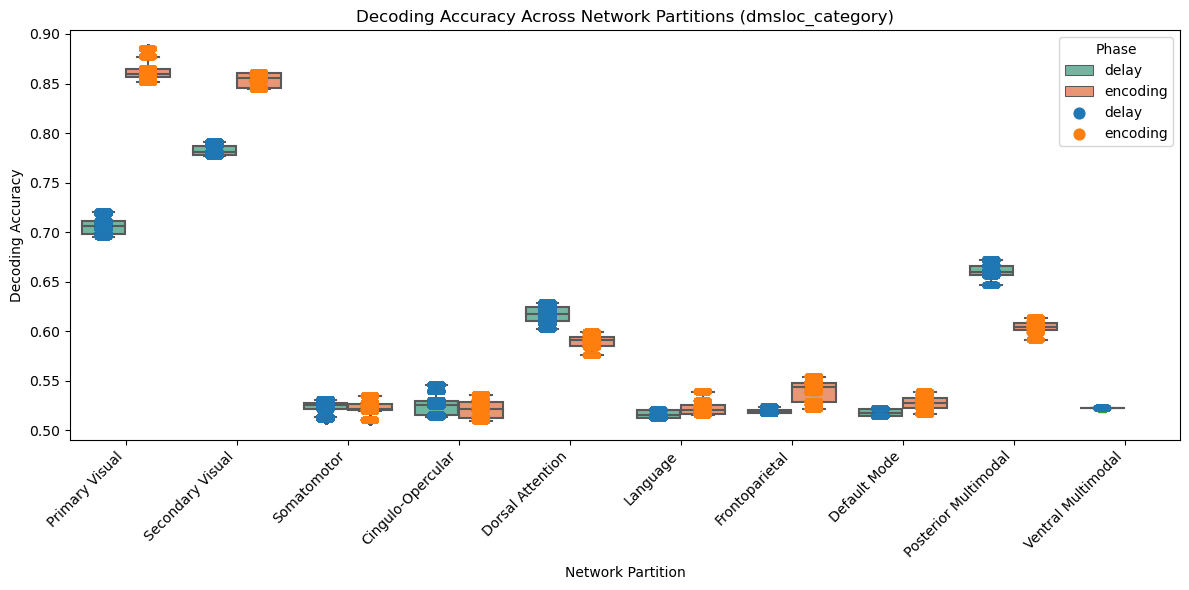

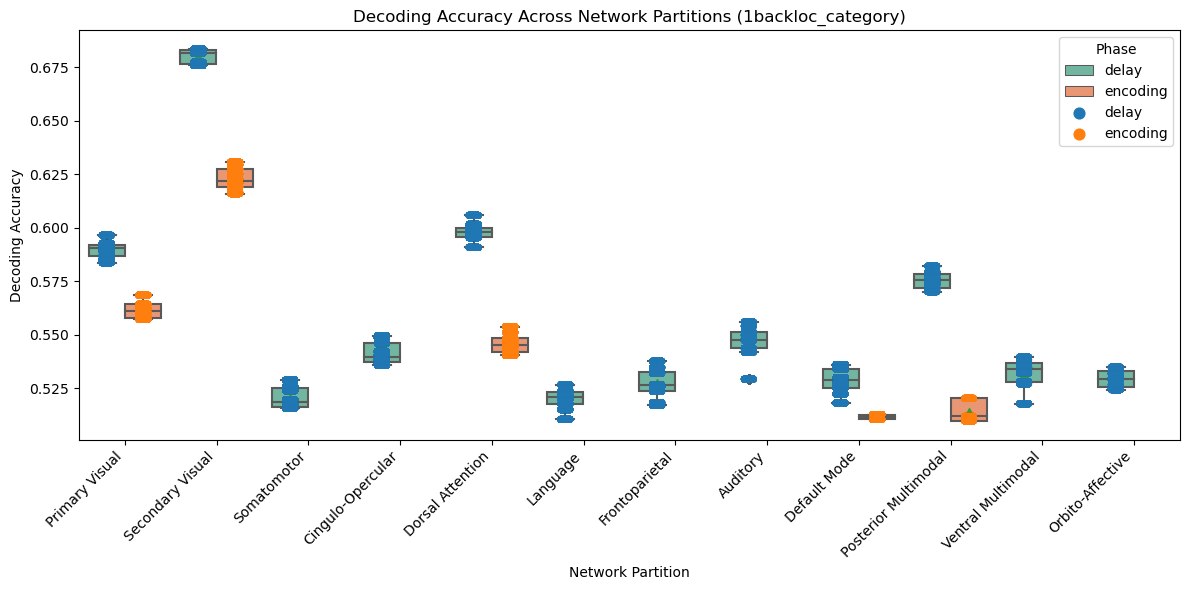

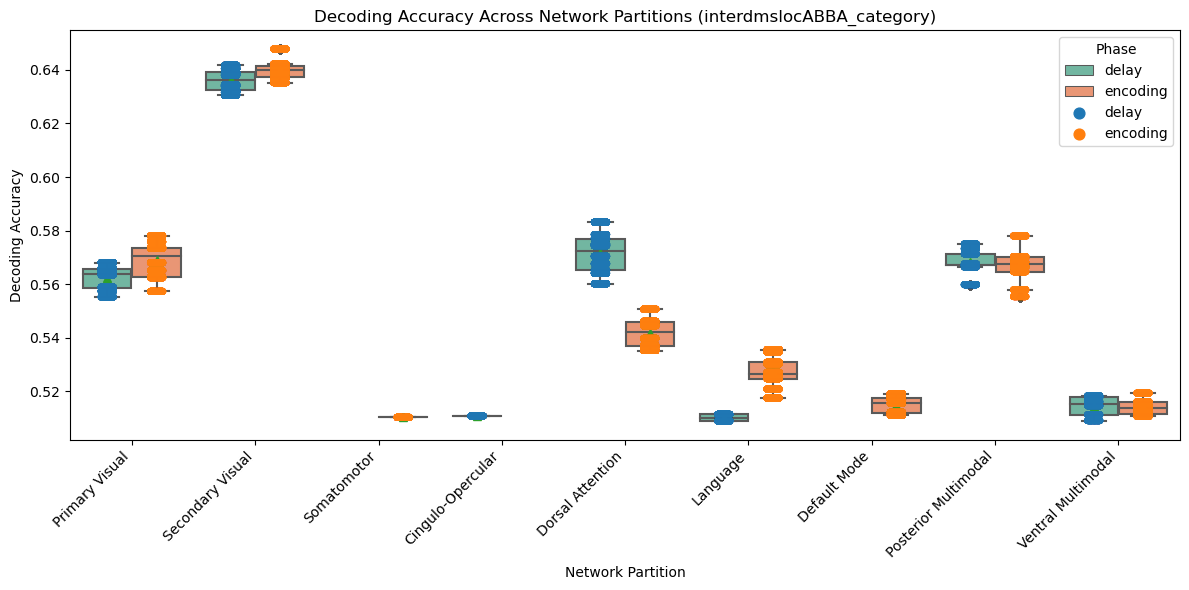

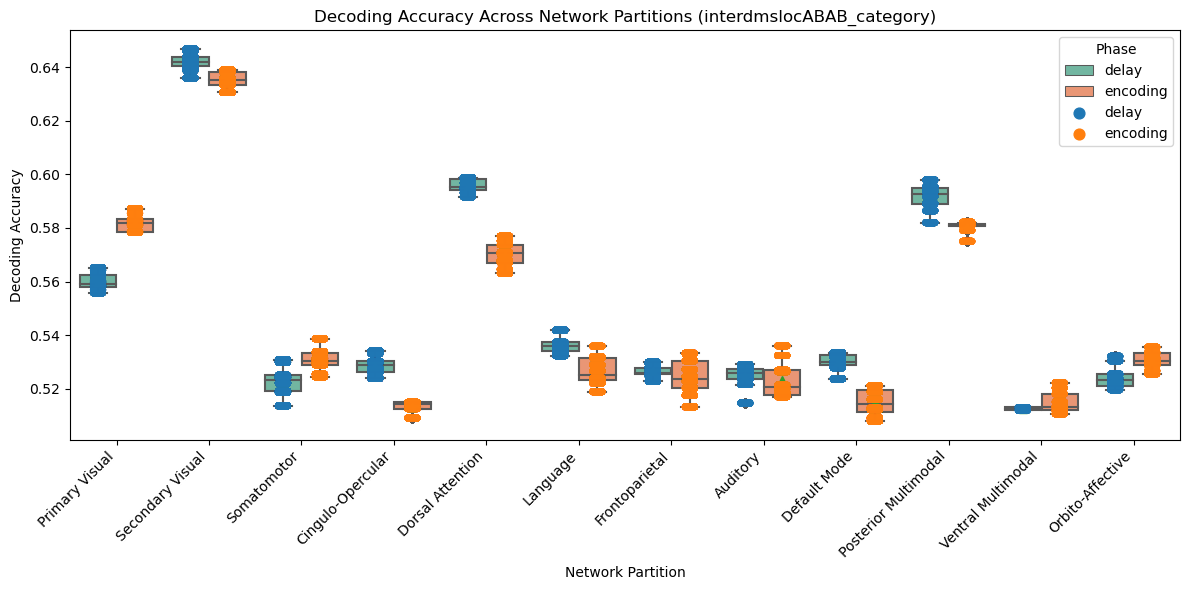

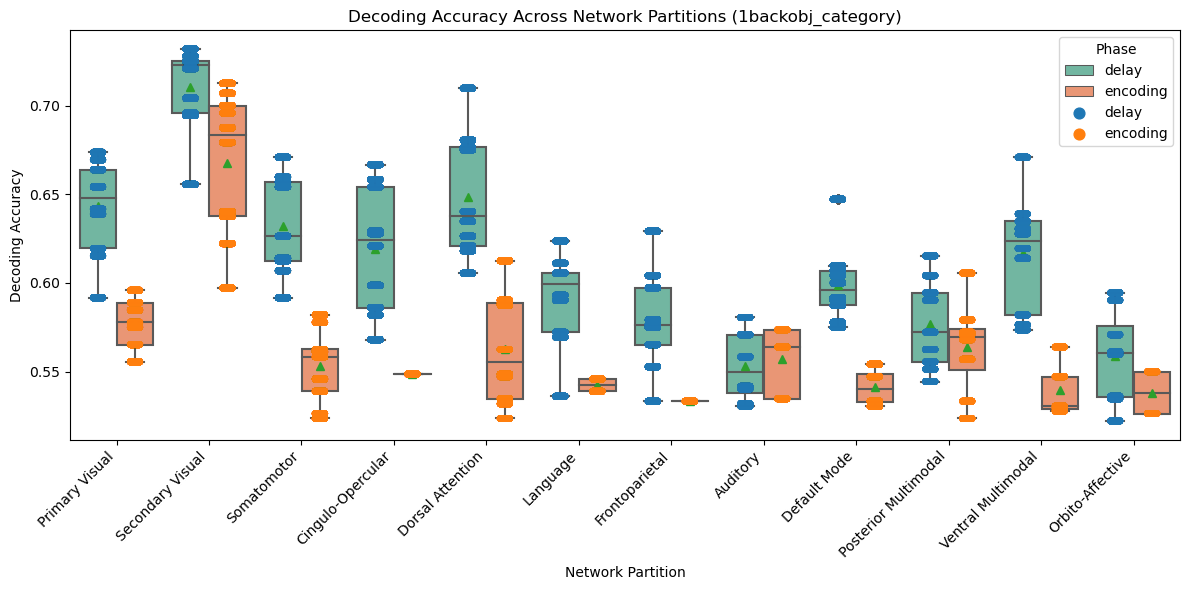

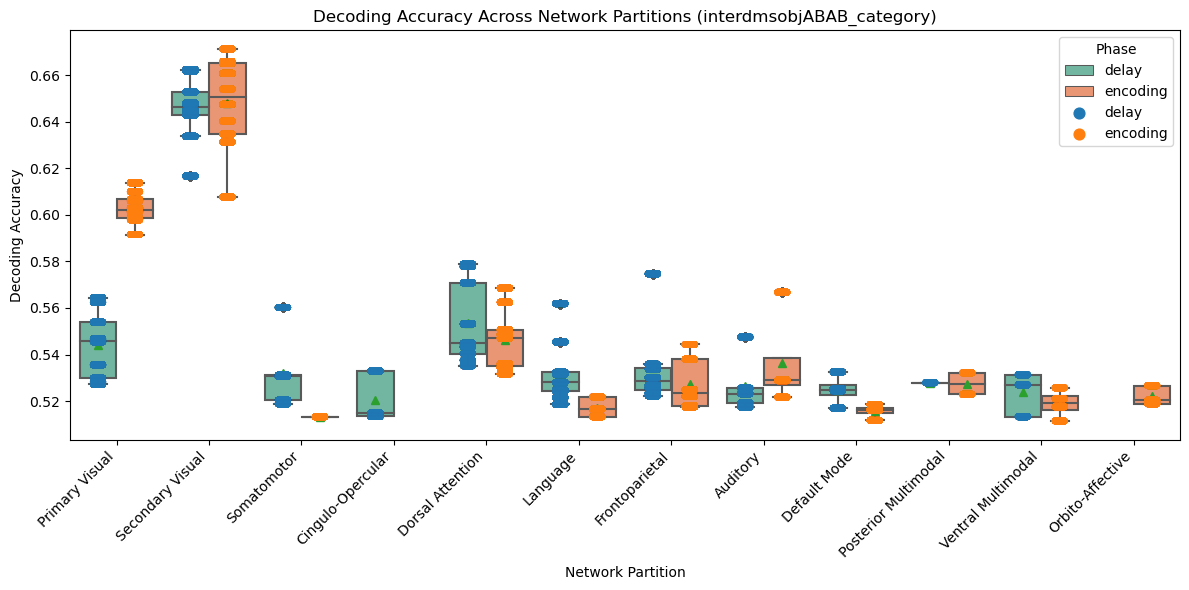

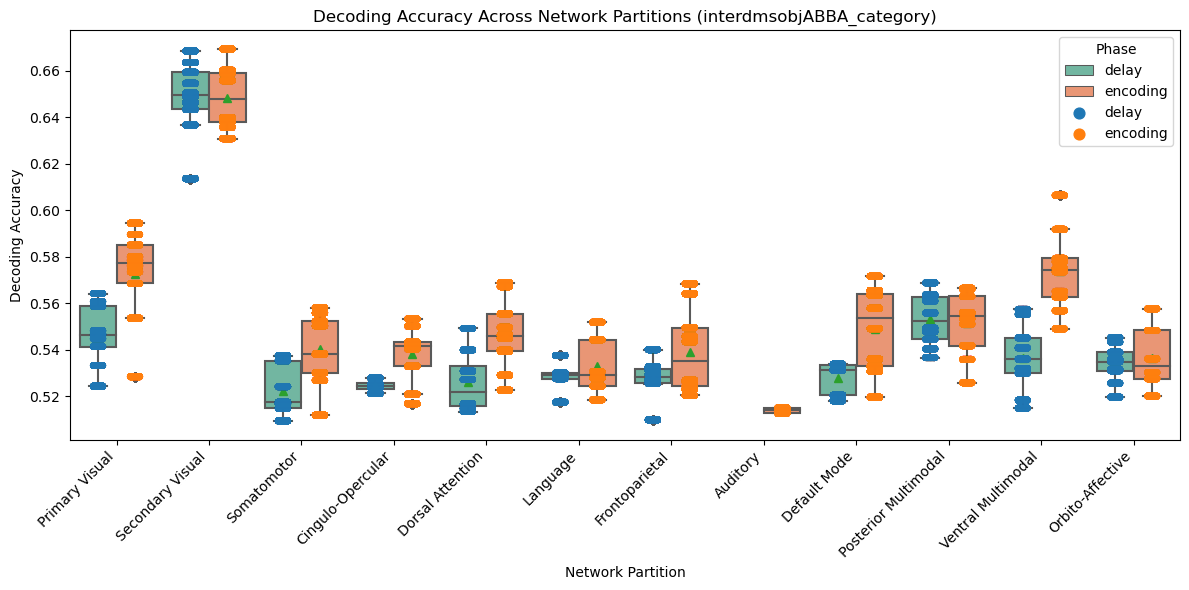

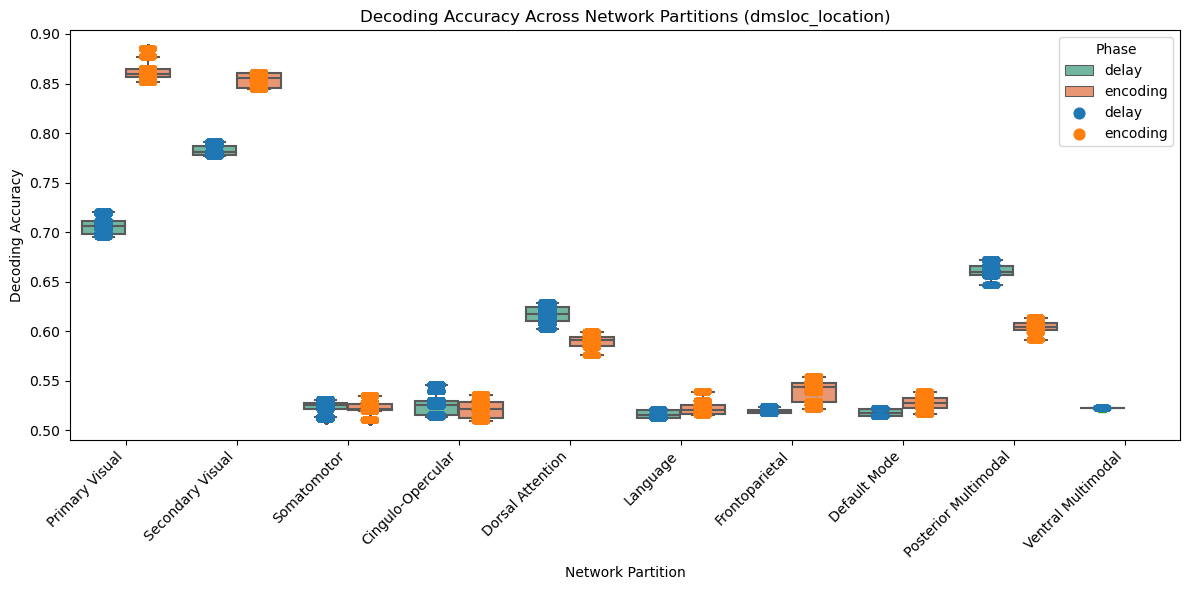

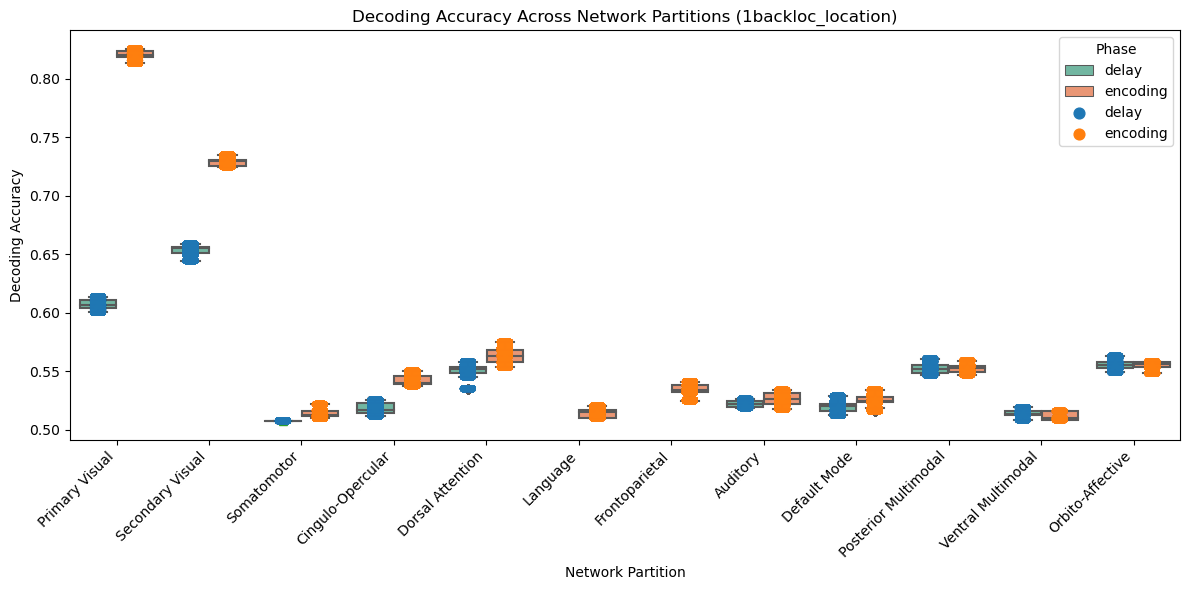

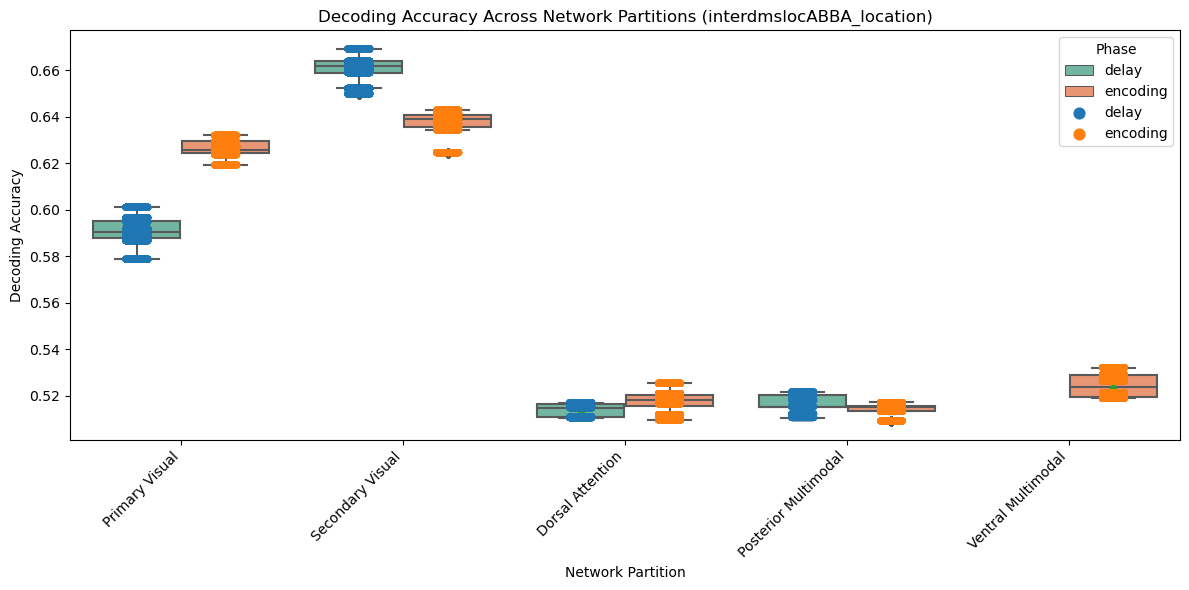

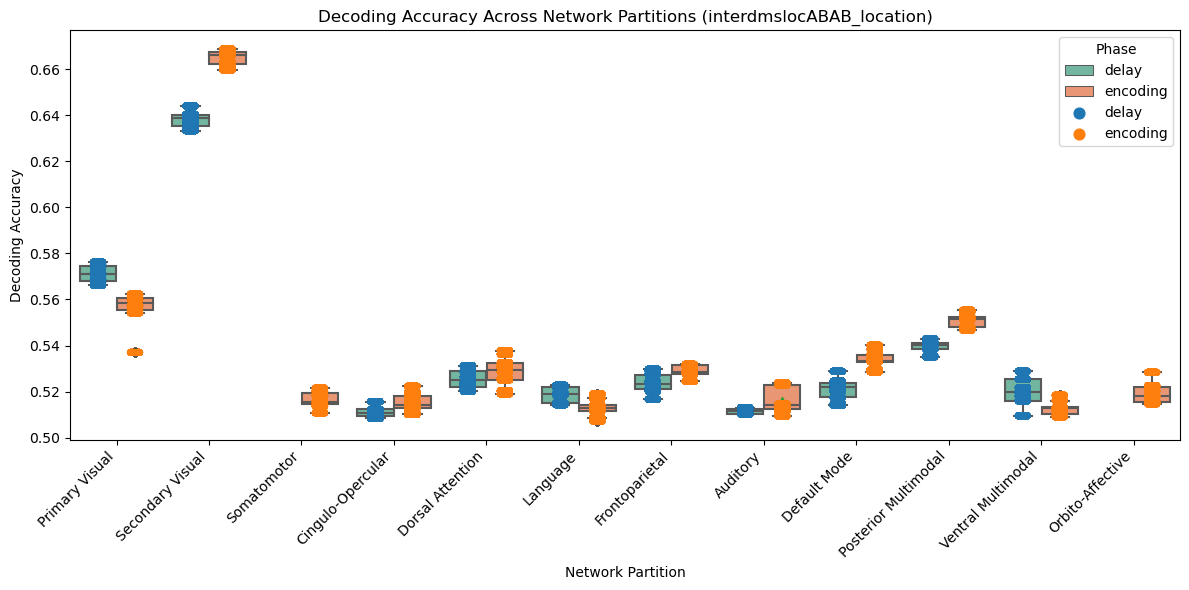

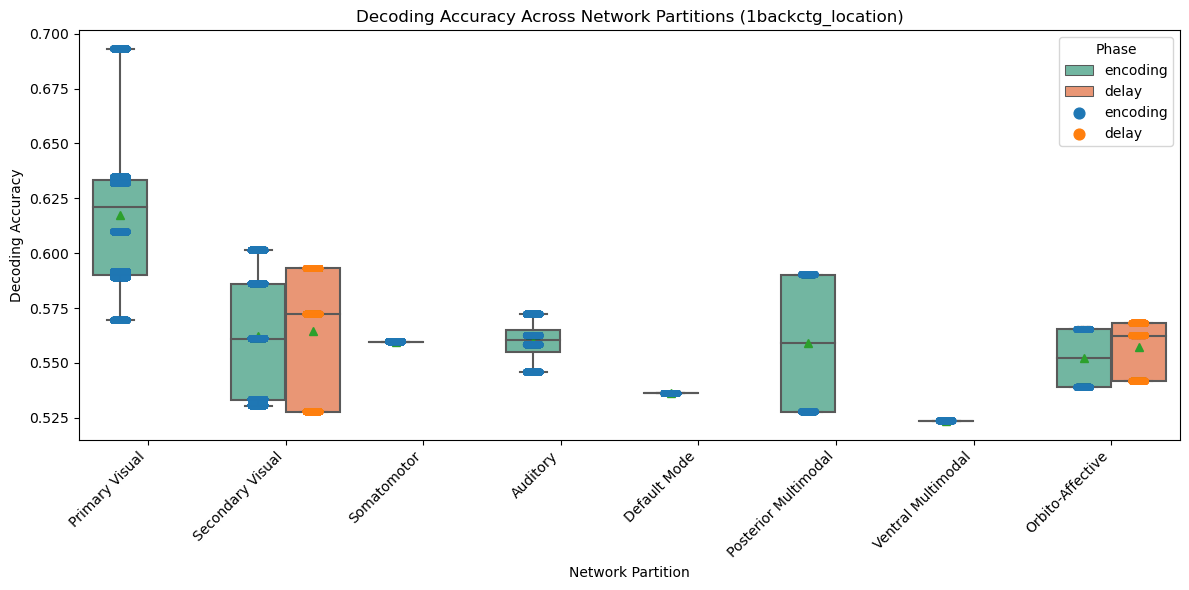

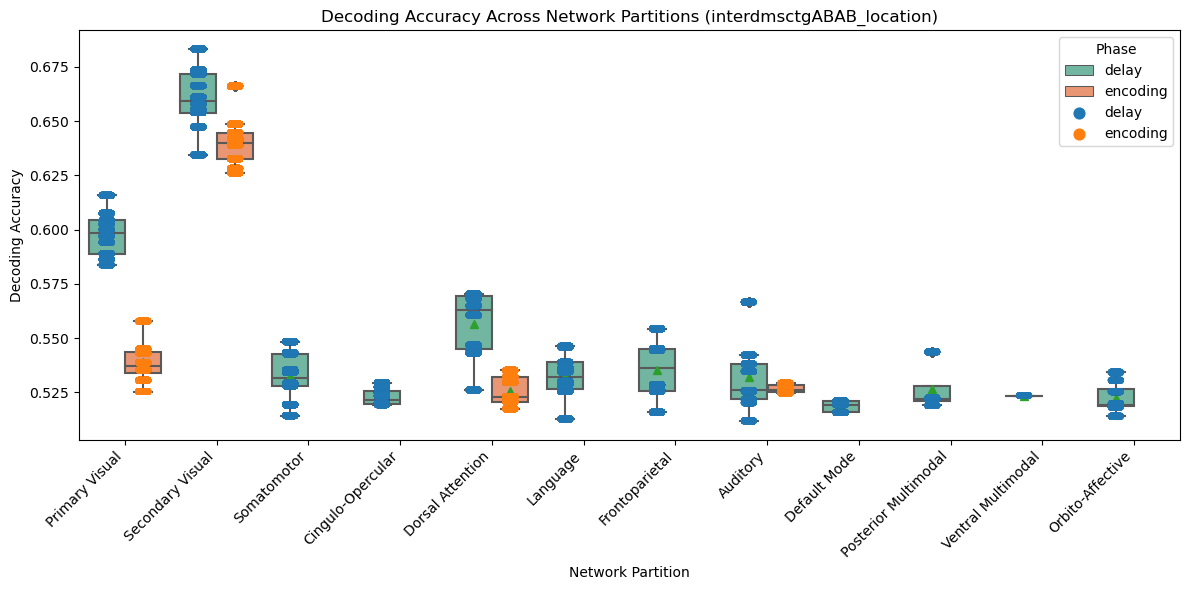

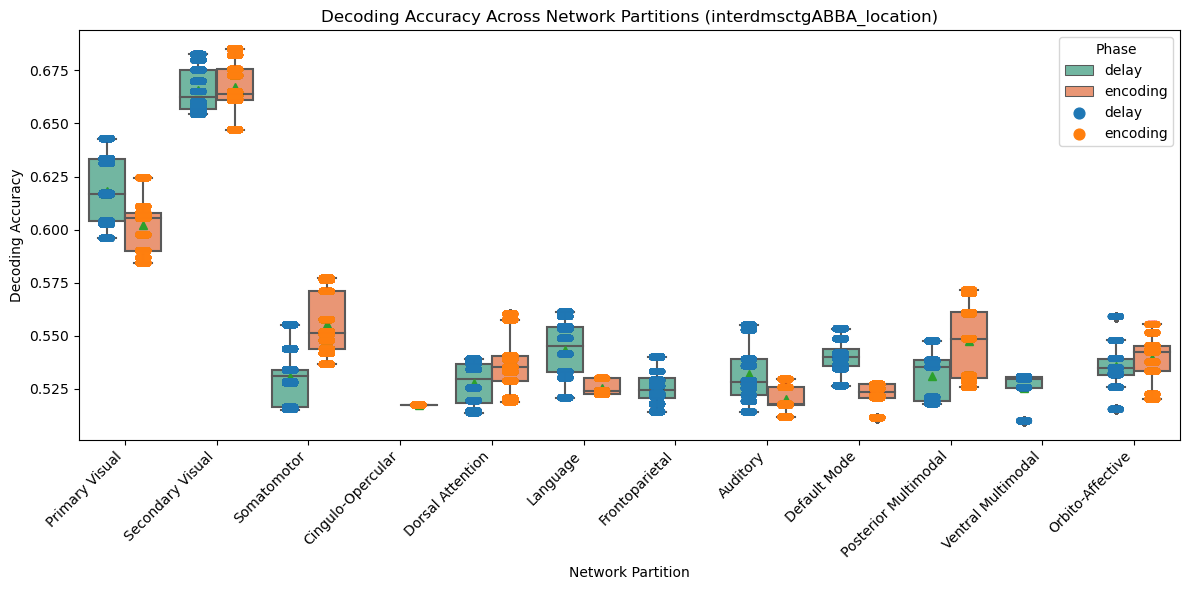

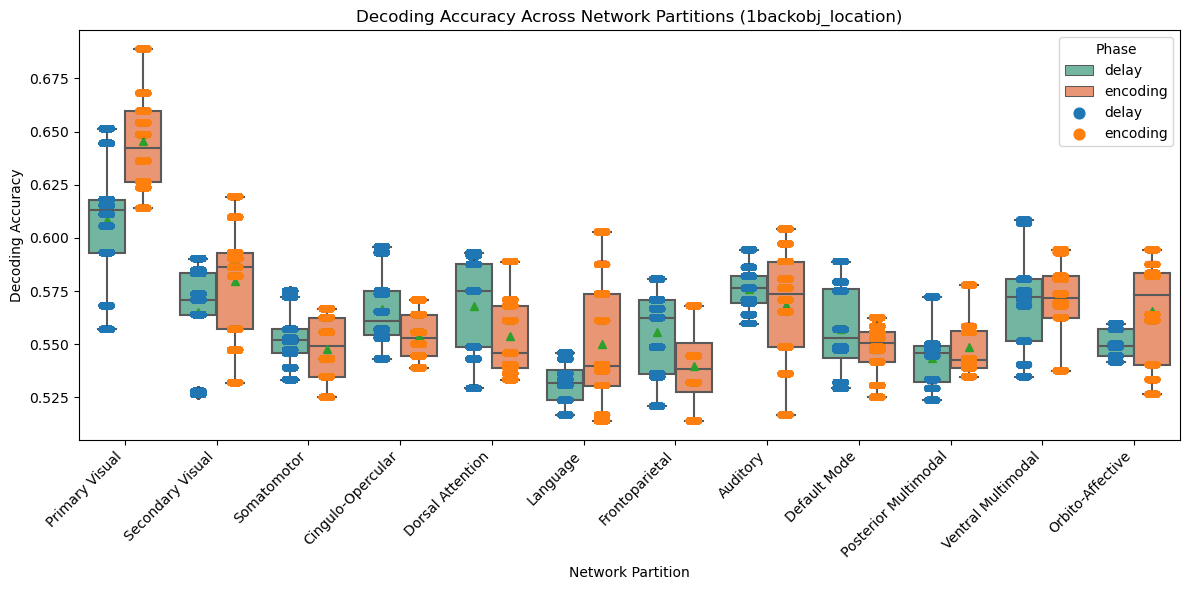

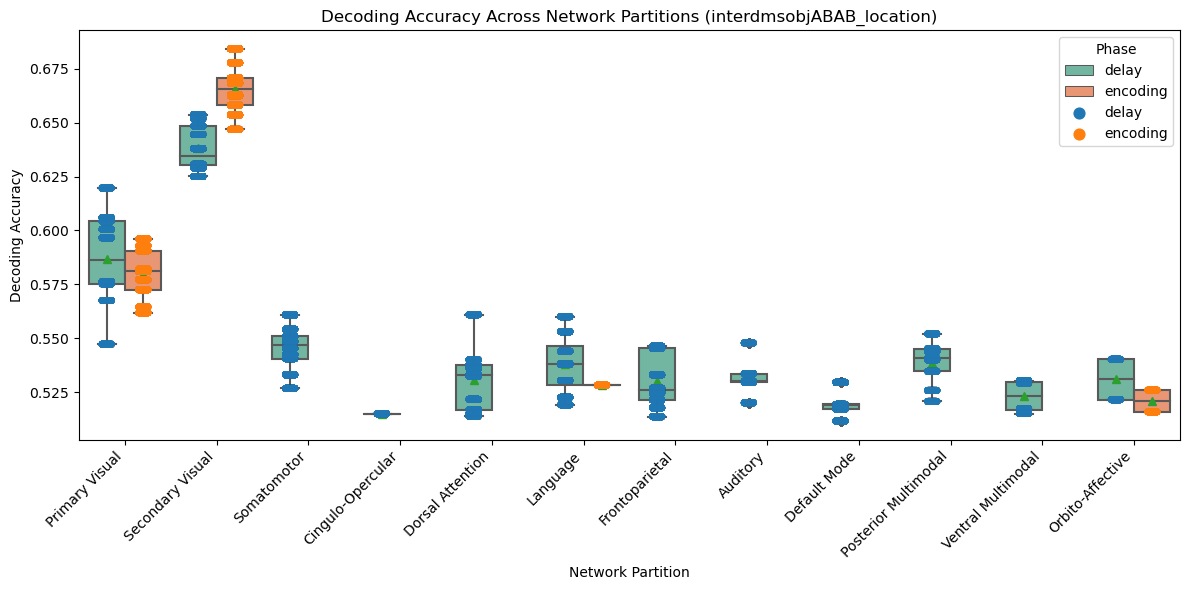

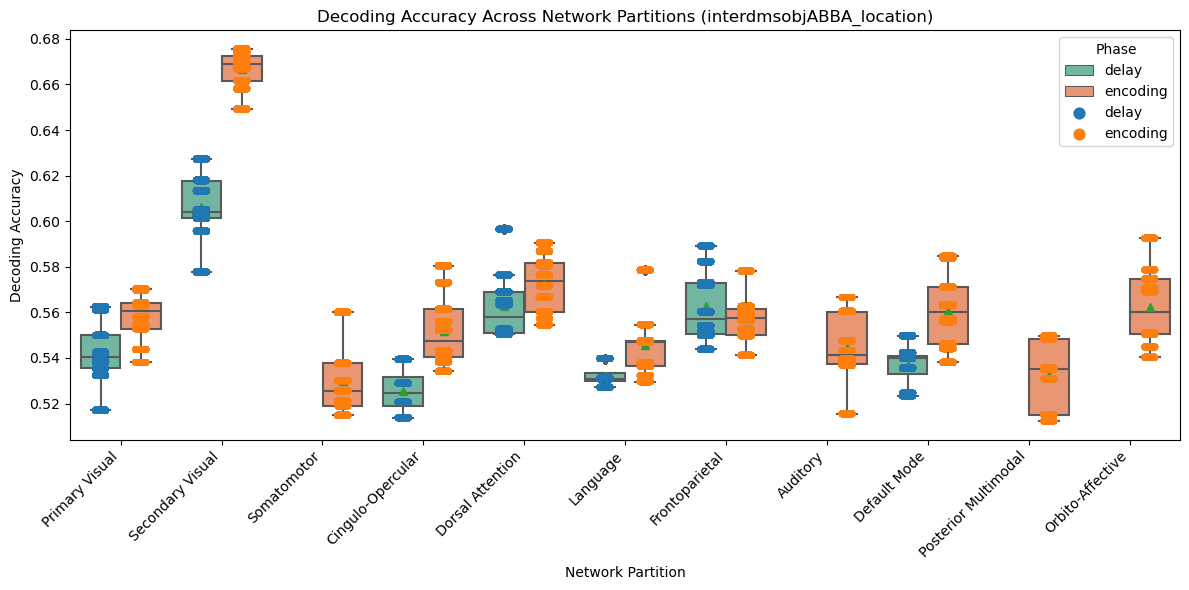

In [7]:
# make the plot at individual task level
# Network partition names mapping
network_partition_names = {
    1: "Primary Visual",
    2: "Secondary Visual",
    3: "Somatomotor",
    4: "Cingulo-Opercular",
    5: "Dorsal Attention",
    6: "Language",
    7: "Frontoparietal",
    8: "Auditory",
    9: "Default Mode",
    10: "Posterior Multimodal",
    11: "Ventral Multimodal",
    12: "Orbito-Affective",
}

for task_name in all_tasks:  # Create a separate figure for each task
    network_acc = {network_idx: {'delay': [], 'encoding': []} for network_idx in network_partition_names.keys()}

    for phase in phases:
        for rep in range(1, n_reps + 1):
            curr_file_path = os.path.join(file_path_base, task_name + f"_{phase}")
            pval_path = os.path.join(curr_file_path, f"p_values_map_corrected_rep{rep}.npy")

            if not os.path.exists(pval_path):
                print(f"Data not exist for {phase} {task_name} rep{rep}")
                break

            # Load necessary data
            p_values_map = np.load(os.path.join(curr_file_path, f"p_values_map_rep{rep}.npy"))
            regionwise_acc = np.load(os.path.join(curr_file_path, f"regionwise_acc_rep{rep}.npy"))

            # FDR correction
            reject, pvals_corrected, _, _ = multipletests(p_values_map.squeeze(), alpha=0.05, method='fdr_bh')
            fdr_corrected_acc = np.zeros_like(regionwise_acc)
            fdr_corrected_acc[reject] = regionwise_acc[reject]

            # Collect accuracy values by network partition
            for network_index in network_partition_names.keys():
                indices = np.where(network_voxelwise_assignment == network_index)[0]
                acc_values = fdr_corrected_acc[indices]

                # Exclude zero values (non-decodable regions)
                acc_values = acc_values[acc_values > 0]
                if len(acc_values) > 0:  # Only store non-zero values
                    network_acc[network_index][phase].extend(acc_values.tolist())

    # Convert to DataFrame for plotting
    plot_data = []
    for network_index, phase_dict in network_acc.items():
        for phase, acc_list in phase_dict.items():
            for acc in acc_list:
                plot_data.append({
                    "Network": network_partition_names[network_index],
                    "Accuracy": acc,
                    "Phase": phase
                })

    df = pd.DataFrame(plot_data)

    # Ensure we don't plot empty data
    if not df.empty:
        # Create figure for each task
        plt.figure(figsize=(12, 6))
        sns.boxplot(x="Network", y="Accuracy", hue="Phase", data=df, palette="Set2", showmeans=True)
        sns.stripplot(x="Network", y="Accuracy", hue="Phase", data=df, dodge=True, jitter=True, alpha=0.5, marker='o')

        plt.xlabel("Network Partition")
        plt.ylabel("Decoding Accuracy")
        plt.title(f"Decoding Accuracy Across Network Partitions ({task_name})")
        plt.legend(title="Phase")
        plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for readability
        plt.tight_layout()
        plt.show()


## create heatmap for decoding accuracy between pairs of tasks at network level
make the plot for encoding, delay, encoding * delay separately

In [7]:
all_tasks

['1backctg_category',
 'interdmsctgABAB_category',
 'interdmsctgABBA_category',
 'dmsloc_category',
 '1backloc_category',
 'interdmslocABBA_category',
 'interdmslocABAB_category',
 '1backobj_category',
 'interdmsobjABAB_category',
 'interdmsobjABBA_category',
 'dmsloc_location',
 '1backloc_location',
 'interdmslocABBA_location',
 'interdmslocABAB_location',
 '1backctg_location',
 'interdmsctgABAB_location',
 'interdmsctgABBA_location',
 '1backobj_location',
 'interdmsobjABAB_location',
 'interdmsobjABBA_location']

In [9]:
# generate concatenated decoding accuracy (e.g. [1back loc_loc, 1back loc_ctg])

task_list = ["dmsloc", "1back_loc", "1back_ctg", "1back_obj",  "interdmslocABAB", "interdmslocABBA", "interdmsctgABAB", "interdmsctgABBA","interdmsobjABAB", "interdmsobjABBA"]

task_network_acc = {task_name: {'delay': [], 'encoding': []} for task_name in task_list}

for task_name in task_list:
    for phase in phases:  # "delay" and "encoding"
        network_level_acc = []  # Store accuracy per network for this task & phase
        
        for decoding_feature in ["location", "category"]:
            for network_index in sorted(network_partition_names.keys()):
                acc_values = []

                for rep in range(1, n_reps + 1):
                    curr_file_path = os.path.join(file_path_base, task_name + f"_{decoding_feature}" + f"_{phase}")
                    pval_path = os.path.join(curr_file_path, f"p_values_map_corrected_rep{rep}.npy")

                    if not os.path.exists(pval_path):
                        print(curr_file_path)
                        print(f"Data not exist for {phase} {task_name} rep{rep}")
                        break

                    # Load accuracy map
                    p_values_map = np.load(os.path.join(curr_file_path, f"p_values_map_rep{rep}.npy"))
                    regionwise_acc = np.load(os.path.join(curr_file_path, f"regionwise_acc_rep{rep}.npy"))

                    # FDR correction
                    reject, pvals_corrected, _, _ = multipletests(p_values_map.squeeze(), alpha=0.05, method='fdr_bh')
                    fdr_corrected_acc = np.zeros_like(regionwise_acc)
                    fdr_corrected_acc[reject] = regionwise_acc[reject]

                    # Collect accuracy for the network partition
                    indices = np.where(network_voxelwise_assignment == int(network_index))[0]
                    #  instead of using fdr corrected accuracy, here I use orignal decoding accuracy
#                     acc_values.append(np.mean(fdr_corrected_acc[indices]))  # Include zeros
                    acc_values.append(np.mean(regionwise_acc[indices]))  # Include zeros


                # Median imputation: Replace zero values with median of non-zero values
                acc_values = np.array(acc_values)
                
                network_level_acc.append(np.mean(acc_values))  # Average across reps

        task_network_acc[task_name][phase] = network_level_acc




Data not exist for encoding 1back_loc rep1
Data not exist for encoding 1back_loc rep1
Data not exist for encoding 1back_loc rep1
Data not exist for encoding 1back_loc rep1
Data not exist for encoding 1back_loc rep1
Data not exist for encoding 1back_loc rep1
Data not exist for encoding 1back_loc rep1
Data not exist for encoding 1back_loc rep1
Data not exist for encoding 1back_loc rep1
Data not exist for encoding 1back_loc rep1
Data not exist for encoding 1back_loc rep1
Data not exist for encoding 1back_loc rep1
Data not exist for encoding 1back_loc rep1
Data not exist for encoding 1back_loc rep1
Data not exist for encoding 1back_loc rep1
Data not exist for encoding 1back_loc rep1
Data not exist for encoding 1back_loc rep1
Data not exist for encoding 1back_loc rep1
Data not exist for encoding 1back_loc rep1
Data not exist for encoding 1back_loc rep1
Data not exist for encoding 1back_loc rep1
Data not exist for encoding 1back_loc rep1
Data not exist for encoding 1back_loc rep1
Data not ex

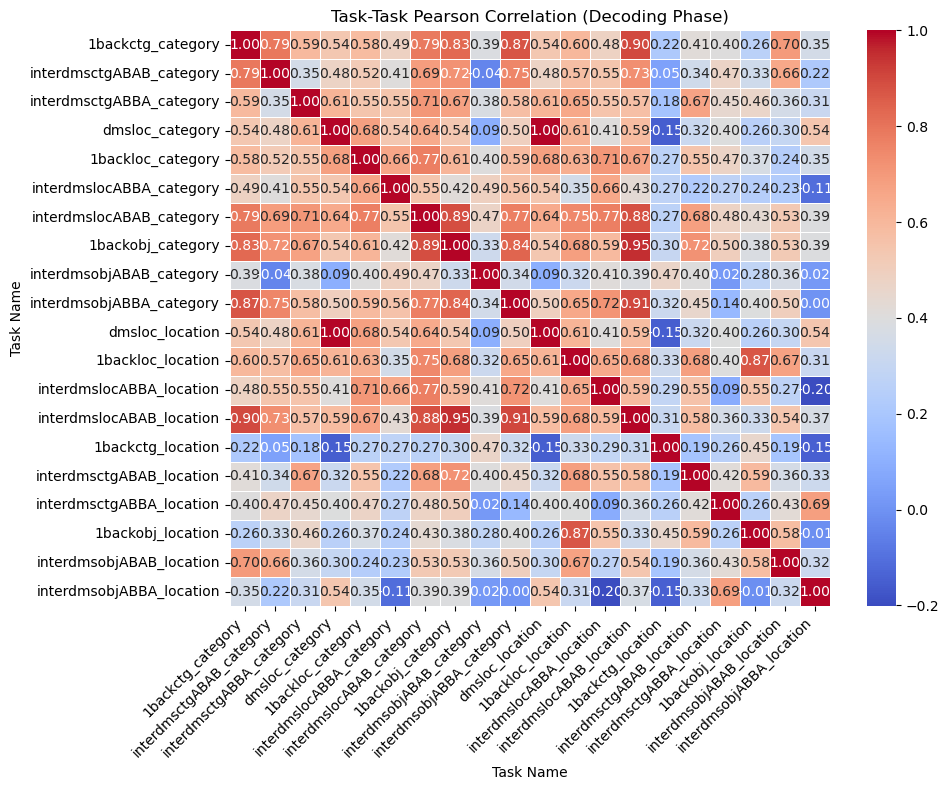

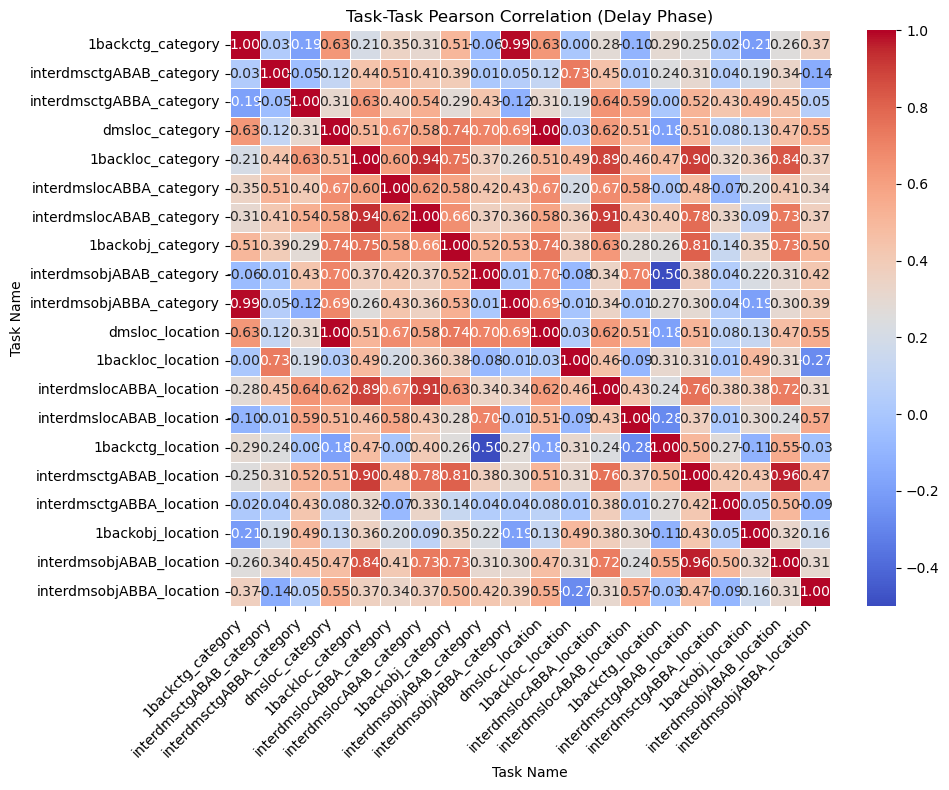

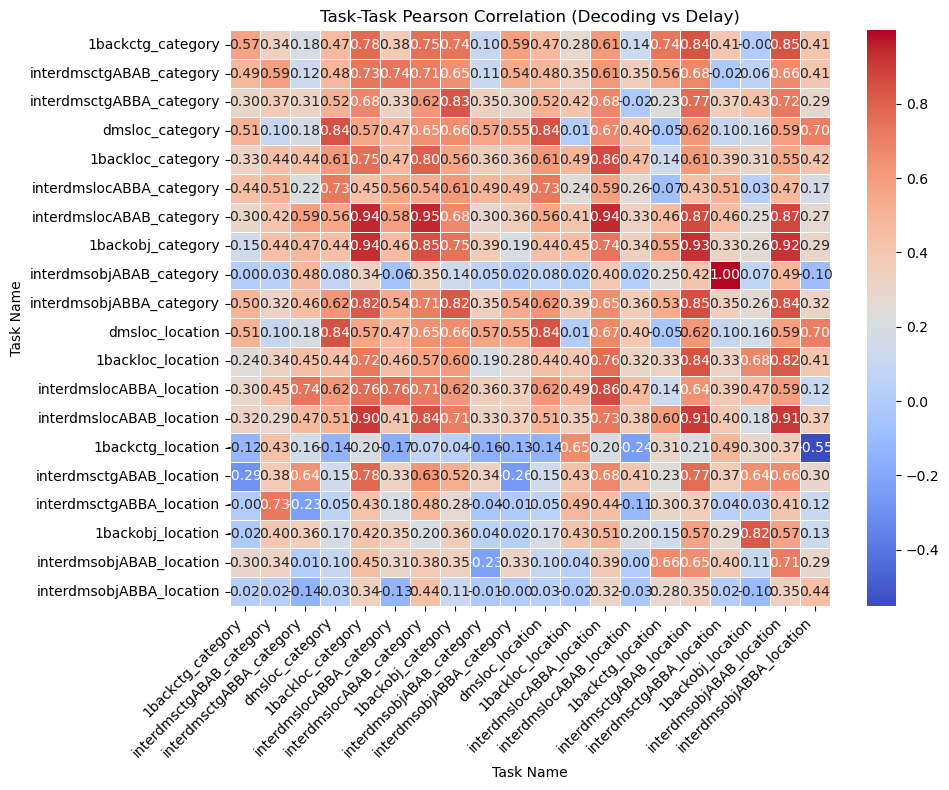

In [43]:
# Initialize storage for network-level accuracy across all tasks
task_network_acc = {task_name: {'delay': [], 'encoding': []} for task_name in all_tasks}

for task_name in all_tasks:
    for phase in phases:  # "delay" and "encoding"
        network_level_acc = []  # Store accuracy per network for this task & phase

        for network_index in sorted(network_partition_names.keys()):
            acc_values = []

            for rep in range(1, n_reps + 1):
                curr_file_path = os.path.join(file_path_base, task_name + f"_{phase}")
                pval_path = os.path.join(curr_file_path, f"p_values_map_corrected_rep{rep}.npy")

                if not os.path.exists(pval_path):
                    print(f"Data not exist for {phase} {task_name} rep{rep}")
                    break

                # Load accuracy map
                p_values_map = np.load(os.path.join(curr_file_path, f"p_values_map_rep{rep}.npy"))
                regionwise_acc = np.load(os.path.join(curr_file_path, f"regionwise_acc_rep{rep}.npy"))

                # FDR correction
                reject, pvals_corrected, _, _ = multipletests(p_values_map.squeeze(), alpha=0.05, method='fdr_bh')
                fdr_corrected_acc = np.zeros_like(regionwise_acc)
                fdr_corrected_acc[reject] = regionwise_acc[reject]

                # Collect accuracy for the network partition
                indices = np.where(network_voxelwise_assignment == int(network_index))[0]
                acc_values.append(np.mean(fdr_corrected_acc[indices]))  # Include zeros

            # Median imputation: Replace zero values with median of non-zero values
            acc_values = np.array(acc_values)
            non_zero_values = acc_values[acc_values > 0]
            
            if len(non_zero_values) > 0:  # If there are non-zero values
                median_value = np.median(non_zero_values)
                acc_values[acc_values == 0] = median_value  # Replace zeros
            else:
                median_value = 0  # If all values are zero, keep them as zero

            network_level_acc.append(np.mean(acc_values))  # Average across reps

        task_network_acc[task_name][phase] = network_level_acc


# Convert to DataFrame for correlation computation
tasks = list(all_tasks)
n_tasks = len(tasks)

# Compute correlation matrices
def compute_correlation_matrix(phase1, phase2):
    correlation_matrix = np.zeros((n_tasks, n_tasks))

    for i, task_i in enumerate(tasks):
        for j, task_j in enumerate(tasks):
            acc_i = task_network_acc[task_i][phase1]
            acc_j = task_network_acc[task_j][phase2]
            correlation_matrix[i, j] = pearsonr(acc_i, acc_j)[0] if np.std(acc_i) > 0 and np.std(acc_j) > 0 else 0

    return pd.DataFrame(correlation_matrix, index=tasks, columns=tasks)

# Generate correlation matrices
corr_decoding = compute_correlation_matrix("encoding", "encoding")
corr_delay = compute_correlation_matrix("delay", "delay")
corr_decoding_vs_delay = compute_correlation_matrix("encoding", "delay")



In [ ]:
# Plot heatmaps
def plot_heatmap(corr_matrix, title):
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
    plt.title(title)
    plt.xlabel("Task Name")
    plt.ylabel("Task Name")
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

plot_heatmap(corr_decoding, "Task-Task Pearson Correlation (Decoding Phase)")
plot_heatmap(corr_delay, "Task-Task Pearson Correlation (Delay Phase)")
plot_heatmap(corr_decoding_vs_delay, "Task-Task Pearson Correlation (Decoding vs Delay)")


<Figure size 1200x1000 with 0 Axes>

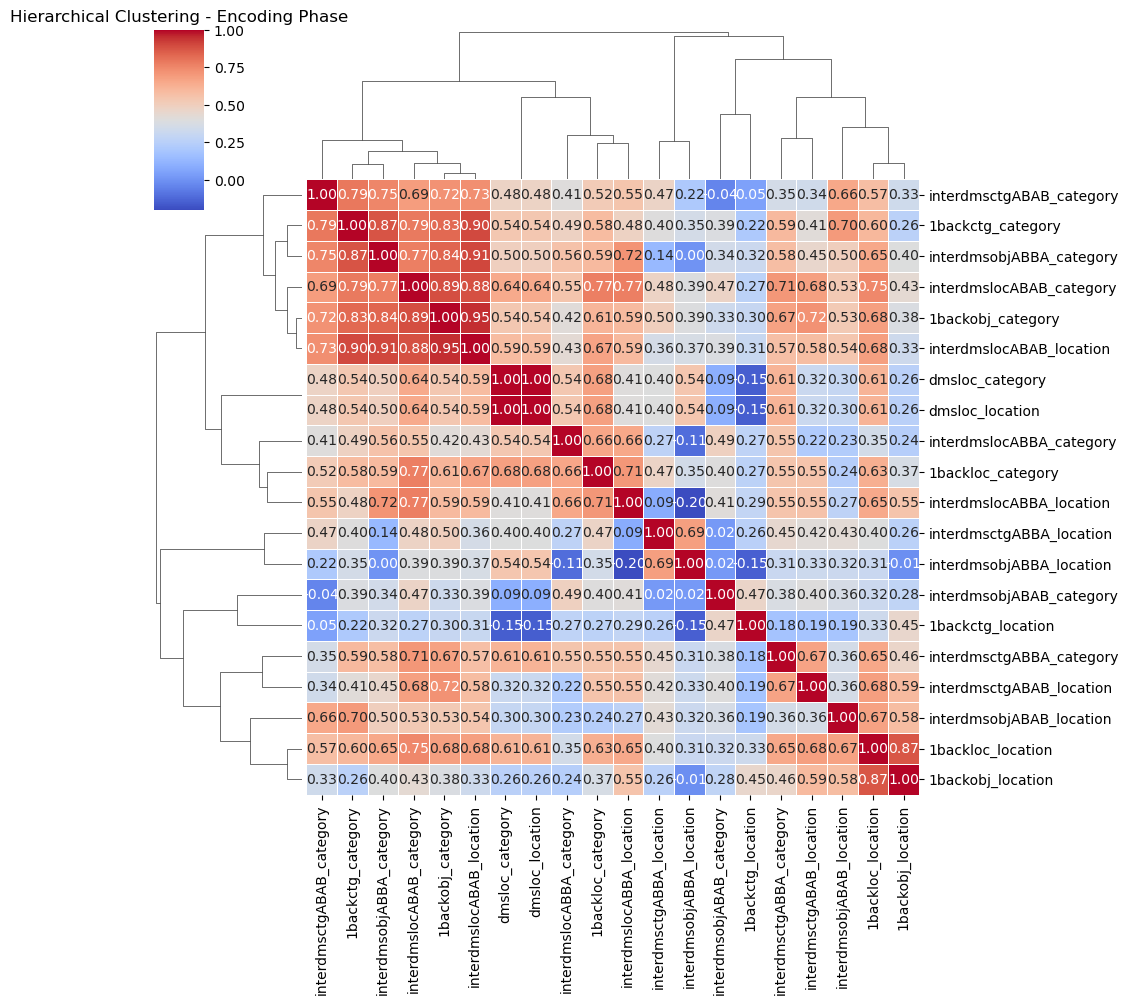

<Figure size 1200x1000 with 0 Axes>

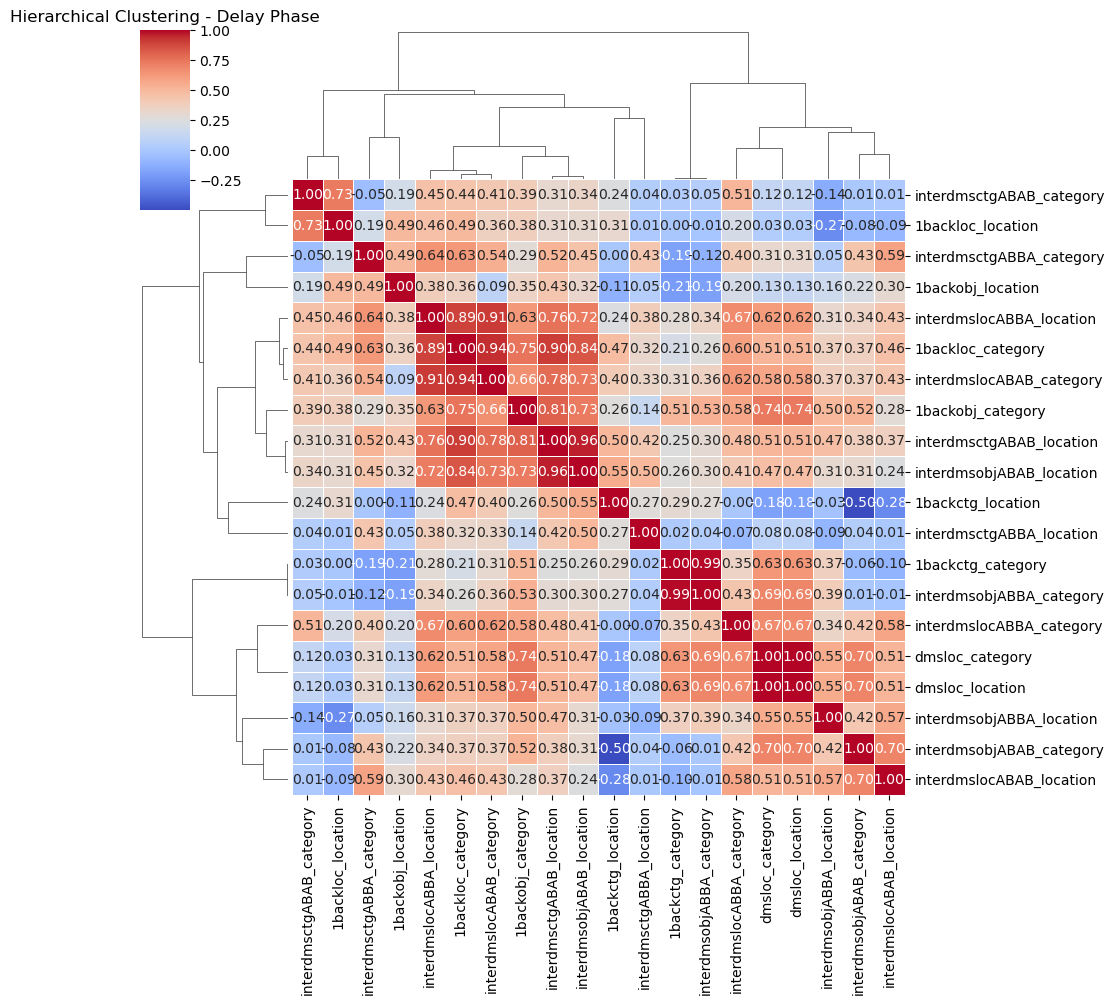

ValueError: Distance matrix 'X' must be symmetric.

In [44]:
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import squareform

def hierarchical_clustering(corr_matrix, title):
    """ Performs hierarchical clustering on the correlation matrix and plots a clustered heatmap. """
    # Convert correlation to distance (1 - correlation)
    distance_matrix = 1 - corr_matrix
    np.fill_diagonal(distance_matrix.values, 0)  # Ensure diagonal is zero (self-similarity)

    # Perform hierarchical clustering
    linkage_matrix = sch.linkage(squareform(distance_matrix), method='ward')

    # Plot the clustered heatmap
    plt.figure(figsize=(12, 10))
    sns.clustermap(corr_matrix, row_linkage=linkage_matrix, col_linkage=linkage_matrix,
                   cmap="coolwarm", annot=True, fmt=".2f", linewidths=0.5)
    plt.title(title)
    plt.show()

# Apply hierarchical clustering to each correlation matrix
hierarchical_clustering(corr_decoding, "Hierarchical Clustering - Encoding Phase")
hierarchical_clustering(corr_delay, "Hierarchical Clustering - Delay Phase")
# hierarchical_clustering(corr_decoding_vs_delay, "Hierarchical Clustering - Encoding vs Delay")


In [22]:
np.where(network_voxelwise_assignment == network_index)[0]

/tmp/ipykernel_3791289/1268842071.py:1: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  np.where(network_voxelwise_assignment == network_index)[0]


array([], dtype=int64)

In [38]:
# concatenate data for each task across features and do correlation heatmap for delay and encoding

# Initialize storage for accuracy across all tasks (combining features)
task_combined_acc = {task_name: {'delay': [], 'encoding': []} for task_name in set(t.split("_")[0] for t in all_tasks)}

for task_prefix in task_combined_acc.keys():
    for phase in phases:  # "encoding" and "delay"
        combined_acc = []  # Store accuracy across all features for the same task

        for network_index in sorted(network_partition_names.keys()):
            acc_values = []

            for rep in range(1, n_reps + 1):
                # Collect accuracy from all feature-based variations of the task
                task_variations = [t for t in all_tasks if t.startswith(task_prefix)]

                for task_name in task_variations:
                    curr_file_path = os.path.join(file_path_base, task_name + f"_{phase}")
                    pval_path = os.path.join(curr_file_path, f"p_values_map_corrected_rep{rep}.npy")

                    if not os.path.exists(pval_path):
                        print(f"Data not exist for {phase} {task_name} rep{rep}")
                        continue  # Skip missing data

                    # Load accuracy map
                    p_values_map = np.load(os.path.join(curr_file_path, f"p_values_map_rep{rep}.npy"))
                    regionwise_acc = np.load(os.path.join(curr_file_path, f"regionwise_acc_rep{rep}.npy"))

                    # FDR correction
                    reject, pvals_corrected, _, _ = multipletests(p_values_map.squeeze(), alpha=0.05, method='fdr_bh')
                    fdr_corrected_acc = np.zeros_like(regionwise_acc)
                    fdr_corrected_acc[reject] = regionwise_acc[reject]

                    # Collect accuracy for the network partition
                    indices = np.where(network_voxelwise_assignment == int(network_index))[0]
                   
                    acc_values.append(np.mean(fdr_corrected_acc[indices]))  # Include zeros
                    
                    
            # Median imputation: Replace zero values with median of non-zero values
            acc_values = np.array(acc_values)
            non_zero_values = acc_values[acc_values > 0]
            
            if len(non_zero_values) > 0:  # If there are non-zero values
                median_value = np.median(non_zero_values)
                acc_values[acc_values == 0] = median_value  # Replace zeros
            else:
                median_value = 0  # If all values are zero, keep them as zero

            
            combined_acc.append(np.mean(acc_values))  # Average across reps
            
            

        task_combined_acc[task_prefix][phase] = combined_acc



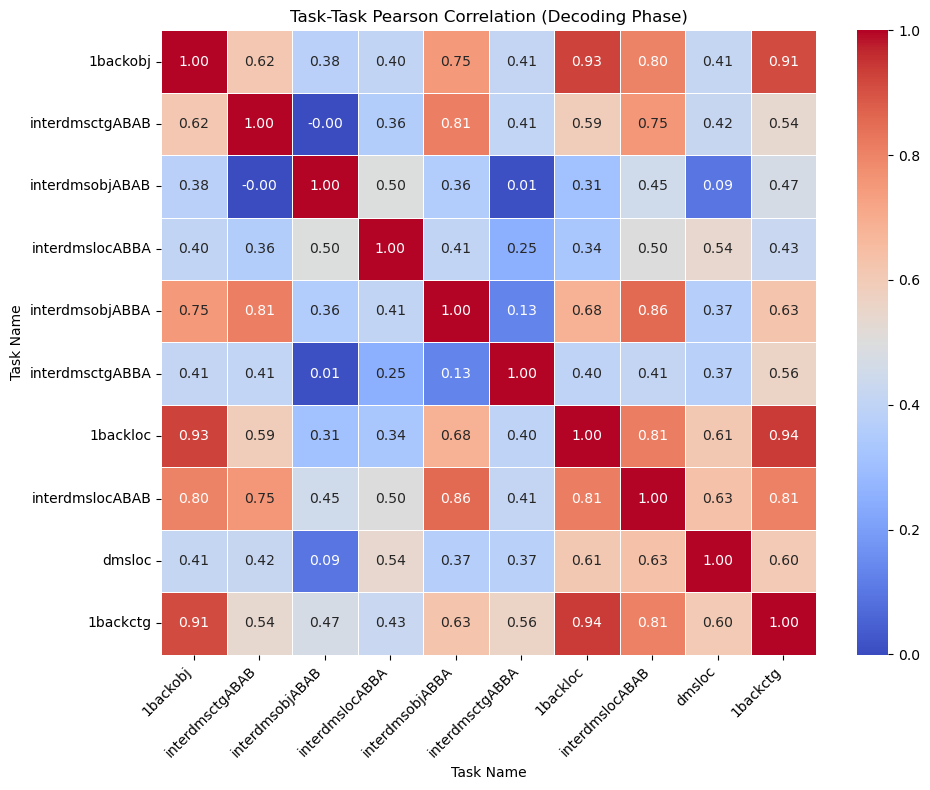

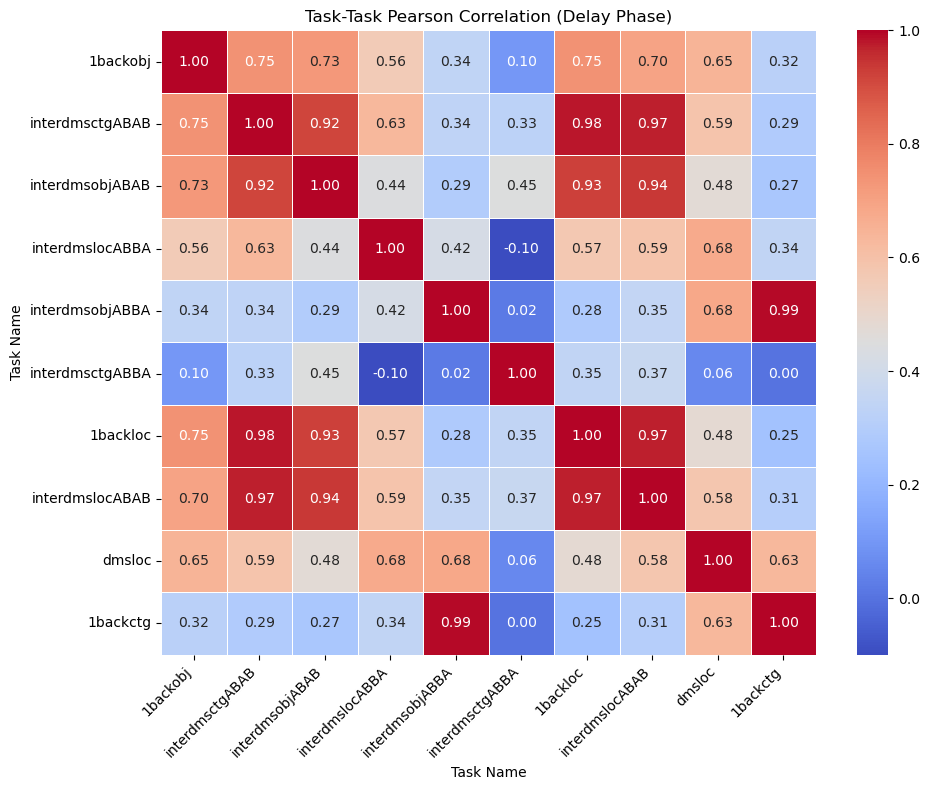

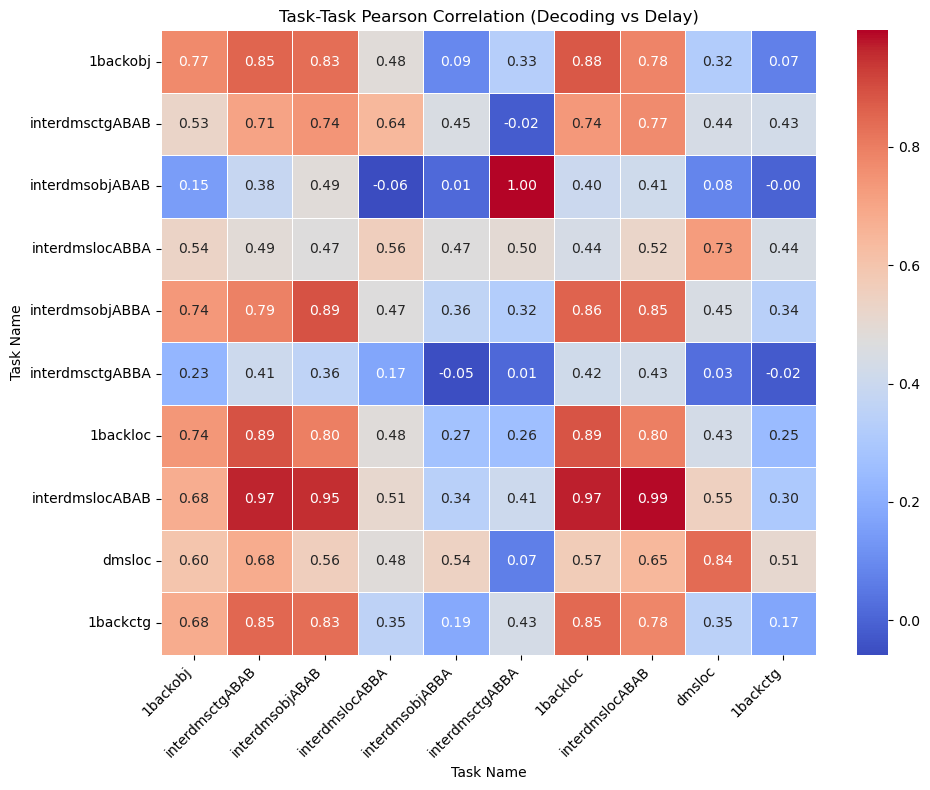

In [42]:
# Convert to DataFrame for correlation computation
tasks = list(task_combined_acc.keys())
n_tasks = len(tasks)

def compute_correlation_matrix(phase1, phase2):
    correlation_matrix = np.zeros((n_tasks, n_tasks))

    for i, task_i in enumerate(tasks):
        for j, task_j in enumerate(tasks):
            acc_i = task_combined_acc[task_i][phase1]
            acc_j = task_combined_acc[task_j][phase2]
            correlation_matrix[i, j] = pearsonr(acc_i, acc_j)[0] if np.std(acc_i) > 0 and np.std(acc_j) > 0 else 0

    return pd.DataFrame(correlation_matrix, index=tasks, columns=tasks)

# Generate correlation matrices
corr_decoding = compute_correlation_matrix("encoding", "encoding")
corr_delay = compute_correlation_matrix("delay", "delay")
corr_decoding_vs_delay = compute_correlation_matrix("encoding", "delay")

# Plot heatmaps
def plot_heatmap(corr_matrix, title):
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
    plt.title(title)
    plt.xlabel("Task Name")
    plt.ylabel("Task Name")
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

plot_heatmap(corr_decoding, "Task-Task Pearson Correlation (Decoding Phase)")
plot_heatmap(corr_delay, "Task-Task Pearson Correlation (Delay Phase)")
plot_heatmap(corr_decoding_vs_delay, "Task-Task Pearson Correlation (Decoding vs Delay)")


## encoding consistency within each network
for each network, check how consistently it encodes a certain feature across tasks
for each feature, make the box plot with y-axis being the percetage of tasks it encodes the feature information and x-axis being network partition name

In [46]:
category_decoding_tasks = ctg_relevant_group + ctg_irrelevant_group
location_decoding_tasks = loc_relevant_group + loc_irrelevant_group



In [49]:

# Define task groups
task_groups = {
    "Category Decoding": category_decoding_tasks,
    "Location Decoding": location_decoding_tasks
}

# Initialize storage for feature encoding percentage
network_encoding_consistency = {group_name: {network_name: [] for network_name in network_partition_names.values()}
                                for group_name in task_groups.keys()}

for group_name, tasks in task_groups.items():
    for network_index, network_name in network_partition_names.items():
        network_index = int(network_index)  # Ensure integer index
        encoding_count = 0  # Count tasks where network encodes the feature

        for task_name in tasks:
            significant_encoding = False  # Track if this network encodes the feature

            for rep in range(1, n_reps + 1):
                curr_file_path = os.path.join(file_path_base, task_name + "_delay")
                pval_path = os.path.join(curr_file_path, f"p_values_map_corrected_rep{rep}.npy")

                if not os.path.exists(pval_path):
                    print(f"Data not exist for delay {task_name} rep{rep}")
                    break

                # Load p-values and accuracy
                p_values_map = np.load(os.path.join(curr_file_path, f"p_values_map_rep{rep}.npy"))
                regionwise_acc = np.load(os.path.join(curr_file_path, f"regionwise_acc_rep{rep}.npy"))

                # FDR correction
                reject, pvals_corrected, _, _ = multipletests(p_values_map.squeeze(), alpha=0.05, method='fdr_bh')
                fdr_corrected_acc = np.zeros_like(regionwise_acc)
                fdr_corrected_acc[reject] = regionwise_acc[reject]

                # Check if the network has at least one significant voxel
                indices = np.where(network_voxelwise_assignment == network_index)[0]
                if np.any(fdr_corrected_acc[indices] > 0.5):
                    significant_encoding = True
                    break  # No need to check further repetitions

            if significant_encoding:
                encoding_count += 1  # This network encodes the feature in this task

        # Compute percentage of tasks where this network encodes the feature
        percentage_encoding = (encoding_count / len(tasks)) * 100 if len(tasks) > 0 else 0
        network_encoding_consistency[group_name][network_name].append(percentage_encoding)



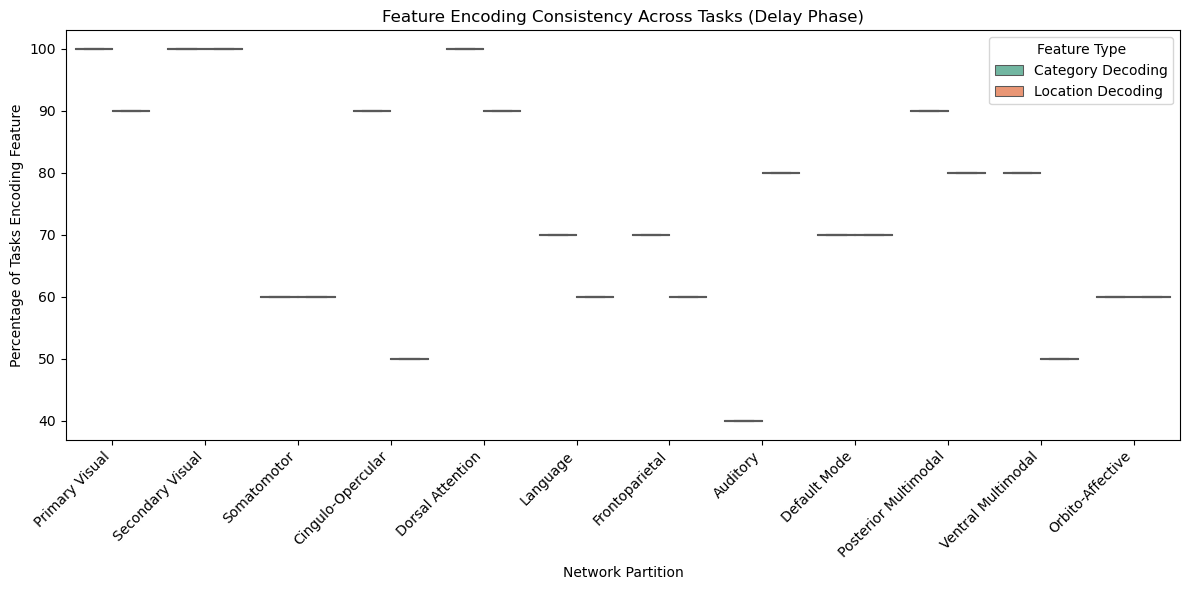

In [51]:
# Convert data into a DataFrame for box plot
plot_data = []
for group_name, networks in network_encoding_consistency.items():
    for network_name, percentages in networks.items():
        for value in percentages:
            plot_data.append({"Feature": group_name, "Network": network_name, "Encoding %": value})

df = pd.DataFrame(plot_data)

# Create the box plot
plt.figure(figsize=(12, 6))
sns.boxplot(x="Network", y="Encoding %", hue="Feature", data=df, palette="Set2")

# Beautify the plot
plt.xticks(rotation=45, ha="right")
plt.ylabel("Percentage of Tasks Encoding Feature")
plt.xlabel("Network Partition")
plt.title("Feature Encoding Consistency Across Tasks (Delay Phase)")
plt.legend(title="Feature Type")
plt.tight_layout()
plt.show()
